In [4]:
import numpy as np
from sympy import symbols
from contextlib import redirect_stdout
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [5]:
K = 20
d = 2
a = np.zeros(d + 1)
a[2] = 1
# a[2], a[4], a[8] = 1/2, -1, 1/8

In [6]:
vars = [symbols(f'x_{i}') for i in range(d)]
# note that x_0 = 1
E = symbols('E')
m = 0
lim = 5 * K
while d + m <= lim:
    t = 4 * (m+1) * E * vars[m]
    if m >= 2:
        t = t + m * (m * m - 1) * vars[m - 2]
    for n in range(1, d):
        t = t - 2 * (n + 2 * m + 2) * a[n] * vars[n + m]
    t = t / (2 * a[d] * (d + 2 * m + 2))
    vars.append(t.simplify())
    m += 1

In [7]:
def genF(energy, shift):
    Fmats = [np.zeros((K, K)) for _ in range(d)] + [np.eye(K)]
    for i in range(K):
        for j in range(K):
            # here we have vars[i+j]
            term = vars[i + j + shift].subs([(E, energy)])
            for k in range(d):
                Fmats[k][i, j] = term.coeff(vars[k])
                if k == 0:
                    Fmats[k][i, j] *= -1
    return Fmats

def create_output(energy, shift, file):
    with redirect_stdout(file):
        print(f'*Energy: {energy}')
        print(d) # mDIM
        print(1) # nBLOCK
        print(K) # bLOCKsTRUCT
        c = np.zeros(d)
        c[-1] = 1
        print(*c)
        Fmats = genF(energy, shift)
        for Fmat in Fmats:
            print(*Fmat.reshape(-1))

In [16]:
def solve(shift):
    Es = np.linspace(0, 10, num = 500)
    ts = np.zeros_like(Es)
    for i in range(Es.shape[0]):
        with open('aho.dat','w') as f:
            create_output(Es[i], shift, f)
        lines = subprocess.run(['sdpa_gmp','aho.dat','aho.result'], capture_output=True).stdout.split(b'\n')
        for line in lines:
            if line.startswith(b'objValPrimal'):
                t = float(line.split(b' ')[2])
                ts[i] = np.log(np.abs(t))
                break
    np.savez(f'ho_K_{K}_shift_{shift}',Es=Es,ts=ts)
    

In [17]:
solve(0)
solve(2)
solve(4)

In [22]:
def create_shift_plot():
    shifts = [0,2,4]
    fig, ax = plt.subplots()
    ax.set_title('log(|t|) vs E with varying shifts')
    ax.set_xlabel('E')
    ax.set_ylabel('log(|t|)')
    for shift in shifts:
        data = np.load(f'ho_K_{K}_shift_{shift}.npz')
        ax.plot(data['Es'], data['ts'], label=f'(K, S) = {(K, shift)}')
    ax.legend()
    ax.grid()
    return fig, ax

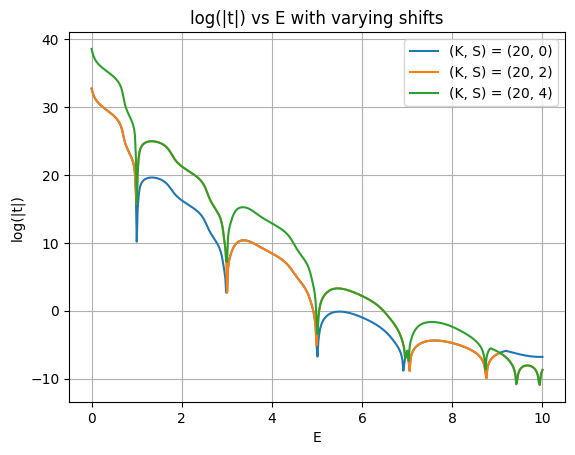

In [23]:
fig, ax = create_shift_plot()
plt.show()

[1.00200401 2.98597194 5.01002004 6.91382766 7.05410822 8.75751503]


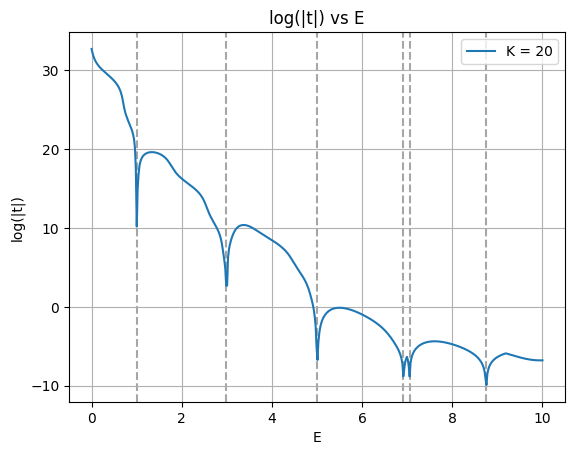

In [21]:
plt.plot(Es, ts, label=f'K = {K}')
dips = Es[find_peaks(-ts,prominence=0.1)[0]]
print(dips)
for dip in dips:
    plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
plt.title('log(|t|) vs E')
plt.xlabel('E')
plt.ylabel('log(|t|)')
plt.legend()
plt.grid()
plt.show()